### Frontalization

#### Environment preparation

In [1]:
# Montowanie Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Przejście do katalogu głównego
%cd /content

# Klonowanie repo
!rm -rf automatic-pain-recognition

print(f"Obecne położenie: {os.getcwd()}")

/content
Obecne położenie: /content


In [ ]:
# Upewnij się, że nazwa użytkownika i repozytorium są poprawne
USERNAME = 'alicka33'
REPO_NAME = 'automatic-pain-recognition'

# Tworzenie poprawnego adresu URL (format: https://<TOKEN>@github.com/...)
REPO_URL = f"https://github.com/{USERNAME}/{REPO_NAME}.git"

print("Rozpoczynam klonowanie...")

# Klonowanie
!git clone {REPO_URL}

# Wejście do katalogu
%cd $REPO_NAME

In [ ]:
# Instalacja wymaganych bibliotek
!pip install -r requirements.txt

In [4]:
import sys
import os

# Dodaj katalog główny projektu do ścieżki systemowej
sys.path.append(os.getcwd())
print(f"Dodano do ścieżki Pythona: {os.getcwd()}")

Dodano do ścieżki Pythona: /content/automatic-pain-recognition


#### MediaPipe Compatibility Fix (Python 3.12+ / January 2026)
Note: Since the Google Colab update in early 2026, MediaPipe has changed its package structure. If you encounter AttributeError: module 'mediapipe' has no attribute 'solutions' or ModuleNotFoundError, please run the two cells below.

In [ ]:
!pip uninstall -y mediapipe
!rm -rf /usr/local/lib/python3.12/dist-packages/mediapipe

# 2. Instalacja wersji zgodnej z 3.12 (bez cache)
!pip install --no-cache-dir mediapipe==0.10.14

# 3. WYMUSZENIE RESTARTU - to zabije sesję i odświeży ścieżki
import os
os.kill(os.getpid(), 9)

### Frontalization

In [5]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

In [6]:
from data_preparation.processing_pipeline_dlib import (
    init_dlib, landmark_obj_to_array, procrustes_normalize,
    frontalize_landmarks, center_by_reference, to_feature_vector, process_frame as dlib_process_frame
)
from data_preparation.processing_pipeline_mediapipe import (
    create_face_mesh, load_reference_keypoints, parse_landmarks_from_results, visualize_raw_detection,
    visualize_frontalized_points, procrustes_analysis,
    center_keypoints, keypoints_to_feature_vector, process_frame as mp_process_frame
)

print("Imports successful!")


Imports successful!


In [7]:
COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
# VIDEO_SAMPLE_PATH = os.path.join(COLAB_ROOT, 'data/BioVid_HeatPain/071309_w_21', '071309_w_21-BL1-081.mp4')
VIDEO_SAMPLE_PATH = os.path.join(COLAB_ROOT, 'data/raw/', 'looking_down.mp4')
# VIDEO_SAMPLE_PATH = os.path.join(COLAB_ROOT, 'data/raw/', 'turned_face.mp4')


Sample frame shape: (640, 480, 3)


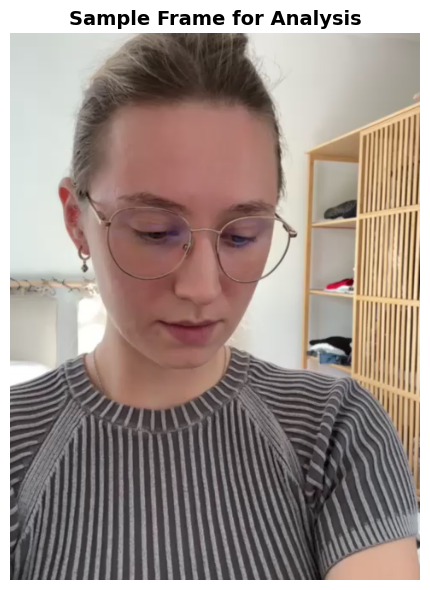

In [26]:
cap = cv2.VideoCapture(VIDEO_SAMPLE_PATH)
ret, sample_frame = cap.read()
cap.release()

if not ret:
    print(f"ERROR: Could not read video from {VIDEO_SAMPLE_PATH}")
else:
    print(f"Sample frame shape: {sample_frame.shape}")

    # Display the sample frame
    plt.figure(figsize=(10, 6))
    frame_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.title('Sample Frame for Analysis', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Dlib

In [12]:
PREDICTOR_PATH = os.path.join(COLAB_ROOT, 'data', 'shape_predictor_68_face_landmarks.dat')
MEAN_FACE_PATH = os.path.join(COLAB_ROOT, 'data', 'landmarks_mean_face.npy')
WEIGHTS_PATH = os.path.join(COLAB_ROOT, 'data', 'frontalization_weights.npy')

dlib_ctx = init_dlib(PREDICTOR_PATH, MEAN_FACE_PATH, WEIGHTS_PATH)
print("Dlib initialized. Frontalization weights loaded:", dlib_ctx.get('frontalization_weights') is not None)



Dlib initialized. Frontalization weights loaded: True


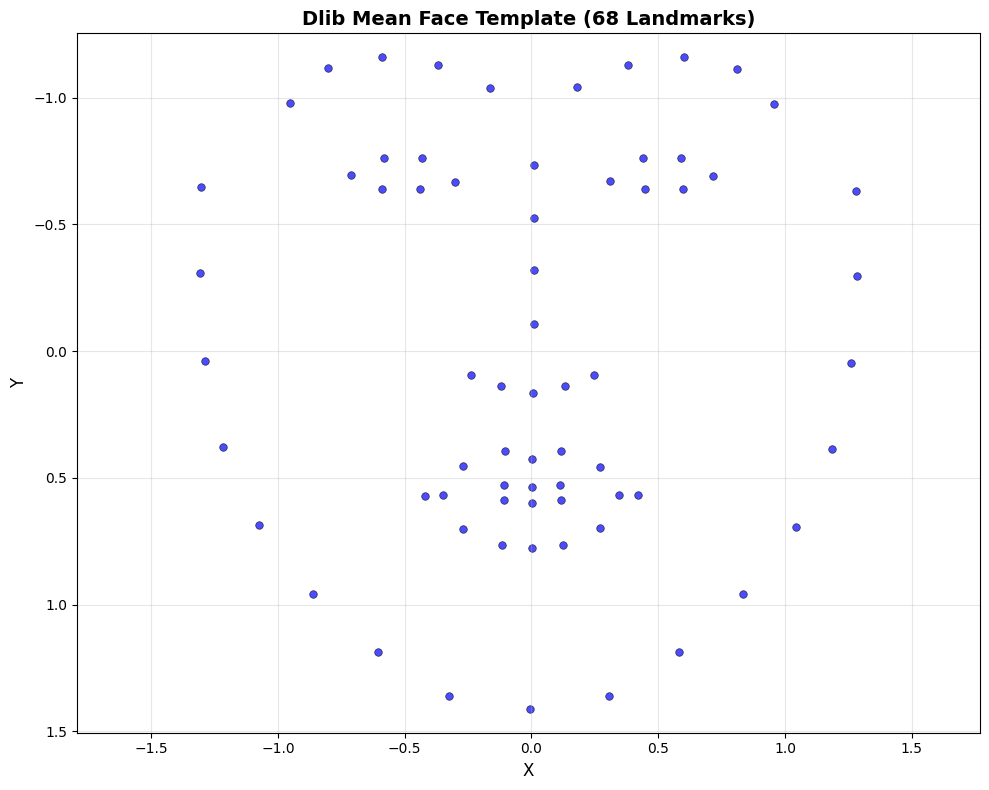

Mean face landmarks shape: (68, 2)
Mean face loaded from: /content/drive/MyDrive/PainRecognitionProject/data/landmarks_mean_face.npy


In [27]:
# Load and display the mean face
mean_face_landmarks = np.load(MEAN_FACE_PATH)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(mean_face_landmarks[:, 0], mean_face_landmarks[:, 1], c='blue', s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_title('Dlib Mean Face Template (68 Landmarks)', fontsize=14, fontweight='bold')
ax.axis('equal')
ax.grid(True, alpha=0.3)
ax.invert_yaxis()  # Invert Y-axis to match image coordinates
plt.tight_layout()
plt.show()

print(f"Mean face landmarks shape: {mean_face_landmarks.shape}")
print(f"Mean face loaded from: {MEAN_FACE_PATH}")

In [13]:
if dlib_ctx is not None:
    dlib_result = dlib_process_frame(
        sample_frame,
        detector=dlib_ctx['detector'],
        predictor=dlib_ctx['predictor'],
        aligner=dlib_ctx['aligner'],
        frontalization_weights=dlib_ctx['frontalization_weights'],
        canonical_reference=dlib_ctx['canonical_reference'],
        frontalize=True,
        center_ref=True,
        ref_index=33,
        visualize=False
    )

    if dlib_result is not None:
        dlib_raw = dlib_result['raw_landmarks']
        dlib_frontal = dlib_result['frontal_landmarks']
        dlib_feature = dlib_result['feature_vector']

        print("✓ Dlib processing successful")
        print(f"  - Raw landmarks shape: {dlib_raw.shape}")
        print(f"  - Frontalized landmarks shape: {dlib_frontal.shape if dlib_frontal is not None else 'None'}")
        print(f"  - Feature vector shape: {dlib_feature.shape if dlib_feature is not None else 'None'}")
    else:
        print("✗ Dlib processing failed - no face detected")
        dlib_result = None
else:
    print("✗ Cannot process with Dlib - not initialized")
    dlib_result = None


✓ Dlib processing successful
  - Raw landmarks shape: (68, 2)
  - Frontalized landmarks shape: (68, 2)
  - Feature vector shape: (136,)


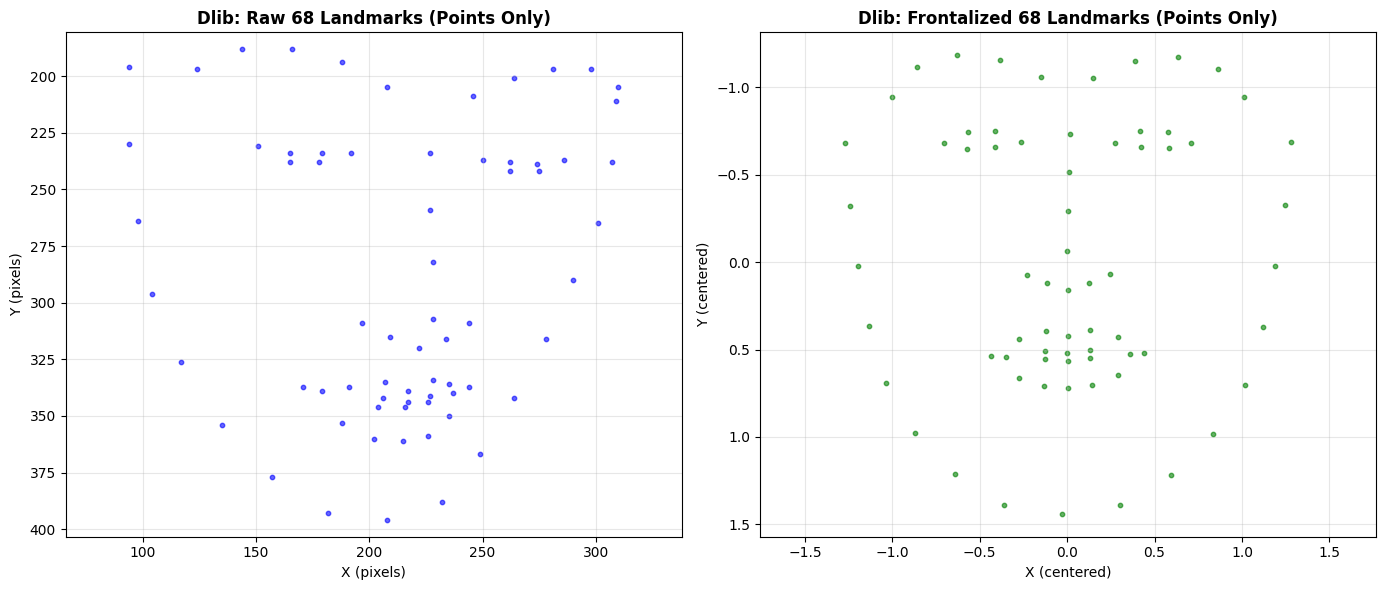

In [39]:
if dlib_result is not None and dlib_frontal is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Raw landmarks - just points
    ax = axes[0]
    ax.scatter(dlib_raw[:, 0], dlib_raw[:, 1], c='blue', s=10, alpha=0.6)
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_title('Dlib: Raw 68 Landmarks (Points Only)', fontsize=12, fontweight='bold')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()

    # Frontalized landmarks - just points
    ax = axes[1]
    frontal_2d = dlib_frontal[:, :2]
    ax.invert_yaxis()
    ax.scatter(frontal_2d[:, 0], frontal_2d[:, 1], c='green', s=10, alpha=0.6)
    ax.set_xlabel('X (centered)')
    ax.set_ylabel('Y (centered)')
    ax.set_title('Dlib: Frontalized 68 Landmarks (Points Only)', fontsize=12, fontweight='bold')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Mediapipe

In [16]:
# Load MediaPipe reference keypoints
mp_ref_kp, mp_ref_ok = load_reference_keypoints(
    os.path.join(COLAB_ROOT, 'data', 'key_points_xyz.npy')
)
print("MediaPipe reference loaded:", mp_ref_ok)

# Create MediaPipe FaceMesh
face_mesh = create_face_mesh()

MediaPipe reference loaded: True


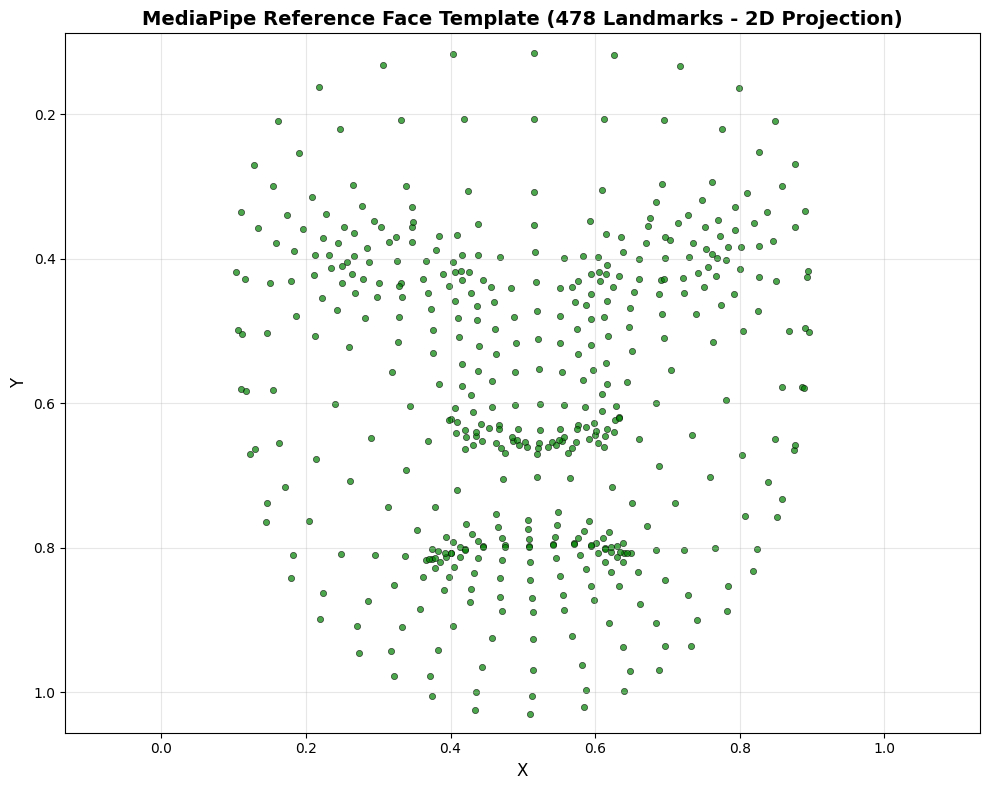

MediaPipe reference keypoints shape: (478, 3)
X range: [0.104, 0.896]
Y range: [0.115, 1.029]
Z range: [-0.197, 0.398]


In [29]:
# Display the MediaPipe reference face (2D projection)
if mp_ref_ok and mp_ref_kp is not None:
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot 2D projection (X, Y only)
    ax.scatter(mp_ref_kp[:, 0], mp_ref_kp[:, 1], c='green', s=20, alpha=0.7, edgecolors='black', linewidth=0.5)
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title('MediaPipe Reference Face Template (478 Landmarks - 2D Projection)', fontsize=14, fontweight='bold')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()  # Invert Y-axis to match image coordinates
    plt.tight_layout()
    plt.show()

    print(f"MediaPipe reference keypoints shape: {mp_ref_kp.shape}")
    print(f"X range: [{mp_ref_kp[:, 0].min():.3f}, {mp_ref_kp[:, 0].max():.3f}]")
    print(f"Y range: [{mp_ref_kp[:, 1].min():.3f}, {mp_ref_kp[:, 1].max():.3f}]")
    print(f"Z range: [{mp_ref_kp[:, 2].min():.3f}, {mp_ref_kp[:, 2].max():.3f}]")
else:
    print("✗ Could not load MediaPipe reference keypoints")

In [17]:
if face_mesh is not None:
    mp_result = mp_process_frame(
        sample_frame,
        face_mesh=face_mesh,
        reference_keypoints_3d=mp_ref_kp,
        use_frontalization=(mp_ref_kp is not None),
        reference_index=2
    )

    if mp_result is not None:
        mp_feature, mp_processed_kp = mp_result

        print("✓ MediaPipe processing successful")
        print(f"  - Processed keypoints shape: {mp_processed_kp.shape}")
        print(f"  - Feature vector shape: {mp_feature.shape}")
    else:
        print("✗ MediaPipe processing failed - no face detected")
        mp_result = None
else:
    print("✗ Cannot process with MediaPipe - not initialized")
    mp_result = None


✓ MediaPipe processing successful
  - Processed keypoints shape: (478, 3)
  - Feature vector shape: (1434,)


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


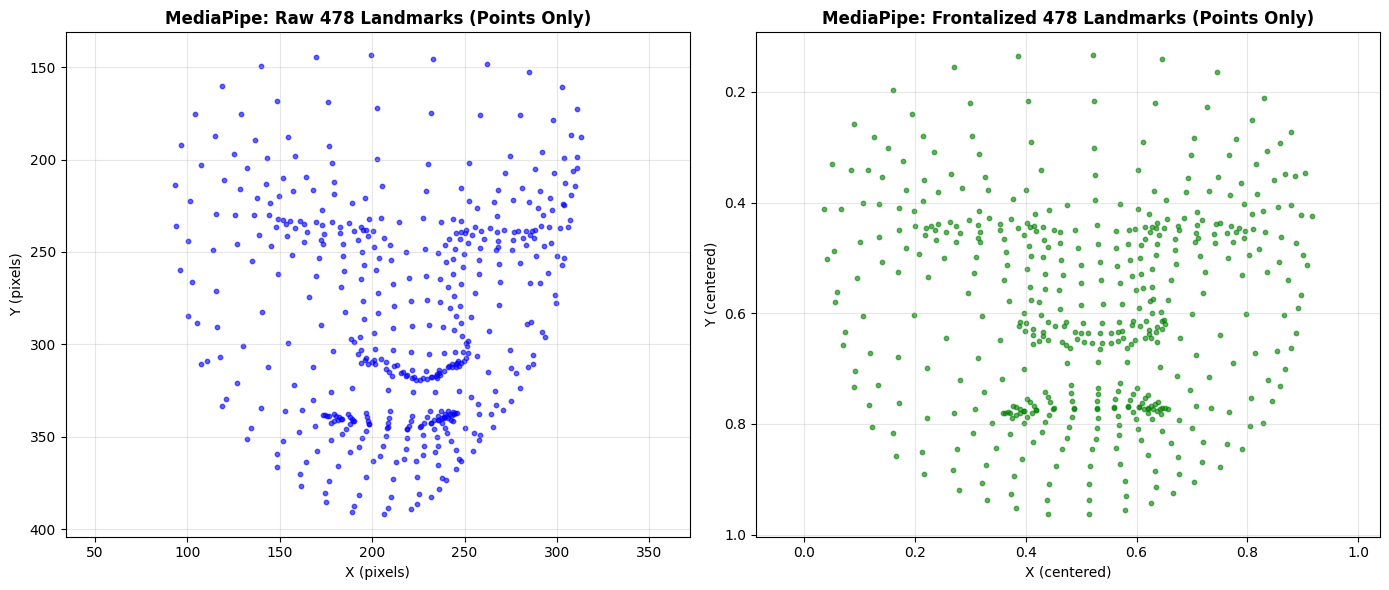

In [23]:
if mp_result is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Raw landmarks - just points
    ax = axes[0]
    frame_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame_rgb)

    if results.multi_face_landmarks:
        landmarks_list = results.multi_face_landmarks[0].landmark
        h, w = sample_frame.shape[:2]

        # Extract raw coordinates
        raw_points = np.array([[lm.x * w, lm.y * h] for lm in landmarks_list])

        # Plot raw points
        ax.scatter(raw_points[:, 0], raw_points[:, 1], c='blue', s=10, alpha=0.6)
        ax.set_xlim(0, w)
        ax.set_ylim(h, 0)  # Invert y-axis
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')

    ax.set_title('MediaPipe: Raw 478 Landmarks (Points Only)', fontsize=12, fontweight='bold')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)

    # Frontalized landmarks - just points
    ax = axes[1]

    # Plot frontalized points in 2D (X, Y)
    ax.scatter(mp_processed_kp[:, 0], mp_processed_kp[:, 1], c='green', s=10, alpha=0.6)
    ax.invert_yaxis()
    ax.set_xlabel('X (centered)')
    ax.set_ylabel('Y (centered)')
    ax.set_title('MediaPipe: Frontalized 478 Landmarks (Points Only)', fontsize=12, fontweight='bold')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

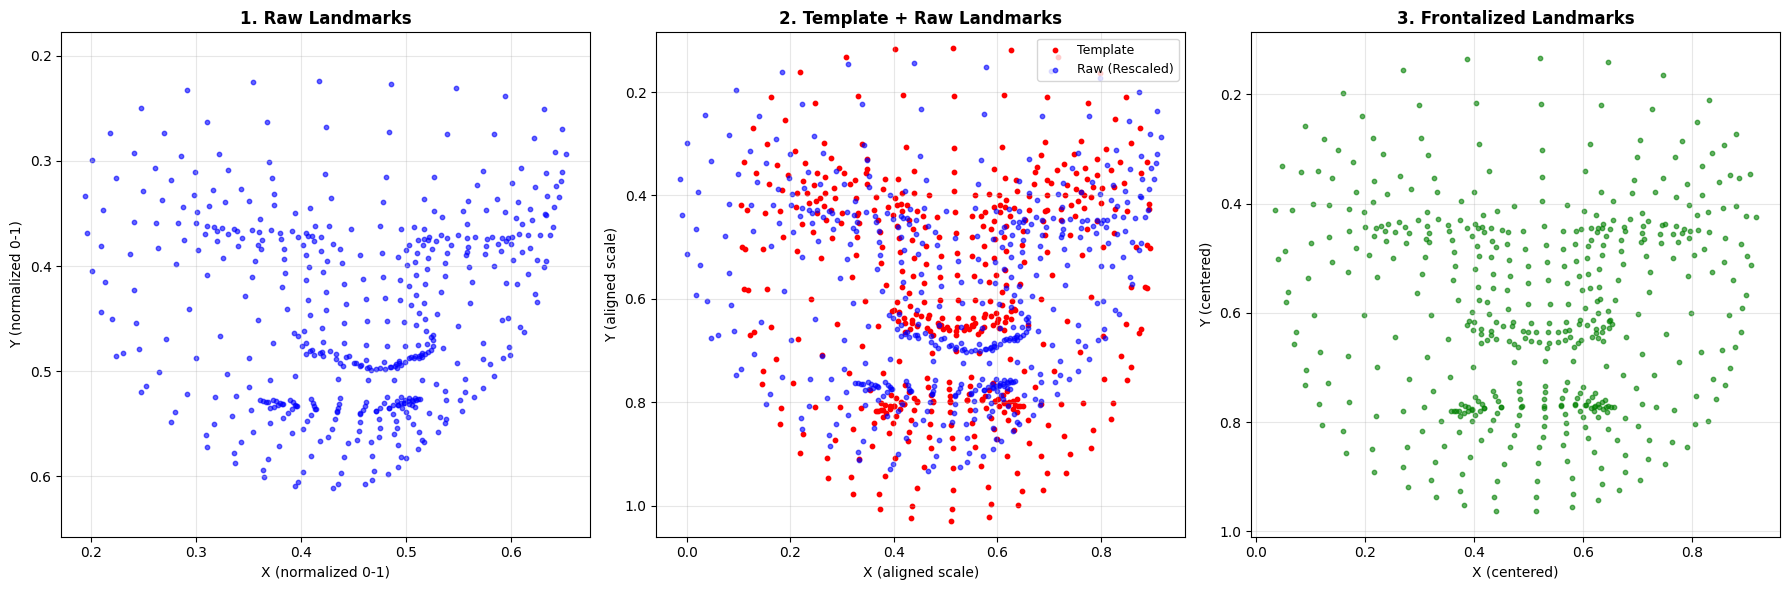

In [44]:
if mp_result is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Przetwarzanie klatki przez MediaPipe
    frame_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame_rgb)

    if results and results.multi_face_landmarks:
        landmarks_list = results.multi_face_landmarks[0].landmark

        # 1. POBIERANIE PUNKTÓW W SKALI ZNORMALIZOWANEJ (0-1)
        # Rezygnujemy z mnożenia przez w i h, aby skala była spójna z resztą
        raw_points_norm = np.array([[lm.x, lm.y] for lm in landmarks_list])

        # --- Plot 1: Raw points only (0-1) ---
        ax = axes[0]
        ax.scatter(raw_points_norm[:, 0], raw_points_norm[:, 1], c='blue', s=10, alpha=0.6)
        ax.set_xlim(0, 1)
        ax.set_ylim(1, 0) # Inwersja osi Y
        ax.set_xlabel('X (normalized 0-1)')
        ax.set_ylabel('Y (normalized 0-1)')
        ax.set_title('1. Raw Landmarks', fontsize=12, fontweight='bold')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)

        # --- Plot 2: Template and raw points overlaid (Wyrównana skala) ---
        ax = axes[1]
        if mp_ref_kp is not None:
            # 1. Obliczamy środek i rozpiętość dla obu zestawów
            raw_mean = raw_points_norm.mean(axis=0)
            ref_mean = mp_ref_kp[:, :2].mean(axis=0)

            raw_scale = np.linalg.norm(raw_points_norm - raw_mean)
            ref_scale = np.linalg.norm(mp_ref_kp[:, :2] - ref_mean)

            # 2. Przeskalowujemy surowe punkty, aby pasowały do "wielkości" template'u
            # Formuła: (Punkt - Środek) * (Skala_Ref / Skala_Raw) + Środek_Ref
            adjusted_raw = (raw_points_norm - raw_mean) * (ref_scale / raw_scale) + ref_mean

            # Rysujemy Template
            ax.scatter(mp_ref_kp[:, 0], mp_ref_kp[:, 1], c='#FF0000', s=10, alpha=1.0, label='Template')
            # Rysujemy dopasowane surowe punkty
            ax.scatter(adjusted_raw[:, 0], adjusted_raw[:, 1], c='blue', s=10, alpha=0.6, label='Raw (Rescaled)')

            # Ustawiamy limity wokół template'u
            x_min, x_max = mp_ref_kp[:, 0].min(), mp_ref_kp[:, 0].max()
            y_min, y_max = mp_ref_kp[:, 1].min(), mp_ref_kp[:, 1].max()
            ax.set_xlim(x_min - 0.1, x_max + 0.1)
            ax.set_ylim(y_max + 0.1, y_min - 0.1)
        else:
            # Jeśli brak template'u, rysujemy po prostu surowe
            ax.scatter(raw_points_norm[:, 0], raw_points_norm[:, 1], c='blue', s=10)
            ax.set_xlim(0, 1)
            ax.set_ylim(1, 0)

        ax.set_xlabel('X (aligned scale)')
        ax.set_ylabel('Y (aligned scale)')
        ax.set_title('2. Template + Raw Landmarks', fontsize=12, fontweight='bold')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', fontsize=9)

        # --- Plot 3: Frontalized landmarks (Centered/Procrustes scale) ---
        ax = axes[2]
        ax.scatter(mp_processed_kp[:, 0], mp_processed_kp[:, 1], c='green', s=10, alpha=0.6)

        # Obliczamy limity dynamicznie, bo po centrowaniu punkty są wokół 0
        x_min, x_max = mp_processed_kp[:, 0].min(), mp_processed_kp[:, 0].max()
        y_min, y_max = mp_processed_kp[:, 1].min(), mp_processed_kp[:, 1].max()
        margin = 0.05

        ax.set_xlim(x_min - margin, x_max + margin)
        ax.set_ylim(y_max + margin, y_min - margin) # Inwersja osi Y
        ax.set_xlabel('X (centered)')
        ax.set_ylabel('Y (centered)')
        ax.set_title('3. Frontalized Landmarks', fontsize=12, fontweight='bold')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("✗ No face landmarks detected")